# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from assignment1.cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
cifar10_dir = 'C:\\Users\\wsh\\Downloads\\python\\CS231n\\assignment1\\cs231n\\datasets'
try:
    del x_train, y_train
    del x_test, y_test
except:
    pass

In [4]:
x_train, y_train, x_test, y_test = load_CIFAR10(cifar10_dir)
print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


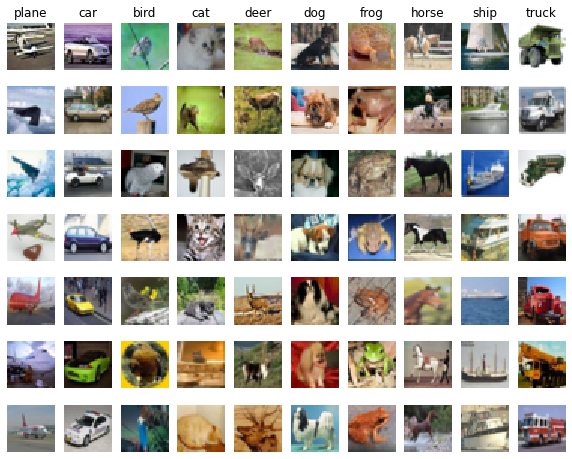

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500
mask = range(num_training, num_training + num_validation)
x_val = x_train[mask]
y_val = y_train[mask]

mask = range(num_training)
x_train = x_train[mask]
y_train = y_train[mask]

mask = np.random.choice(num_training, num_dev, replace=False)
x_dev = x_train[mask]
y_dev = y_train[mask]

mask = range(num_test)
x_test = x_test[mask]
y_test = y_test[mask]

In [7]:
print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [8]:
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_val = np.reshape(x_val, (x_val.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))
x_dev = np.reshape(x_dev, (x_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', x_train.shape)
print('Validation data shape: ', x_val.shape)
print('Test data shape: ', x_test.shape)
print('dev data shape: ', x_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


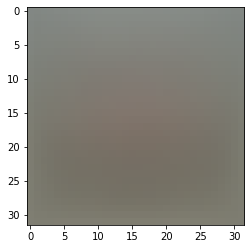

In [9]:
mean_image = np.mean(x_train, axis=0)
print(mean_image[:10])
plt.figure(figsize=(4, 4))
plt.imshow(mean_image.reshape(32, 32, 3).astype('uint8'))
plt.show()

In [10]:
x_train -= mean_image
x_val -= mean_image
x_test -= mean_image
x_dev -= mean_image
print(x_train.shape, x_test.shape, mean_image.shape)

(49000, 3072) (1000, 3072) (3072,)


In [11]:
x_train = np.hstack([x_train, np.ones((x_train.shape[0], 1))])
x_val = np.hstack([x_val, np.ones((x_val.shape[0], 1))])
x_test = np.hstack([x_test, np.ones((x_test.shape[0], 1))])
x_dev = np.hstack([x_dev, np.ones((x_dev.shape[0], 1))])
print(x_train.shape)

(49000, 3073)


## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [12]:
from assignment1.cs231n.classifiers.linear_svm import svm_loss_naive, svm_loss_vectorized
import time

In [13]:
# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_vectorized(W, x_dev, y_dev, 0.00001)
print('loss: %f; graident: %f' % (loss, np.sum(grad)))

loss: 8.518018; graident: -0.000000


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [14]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, x_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from assignment1.cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, x_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, x_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, x_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 16.901229 analytic: 16.901229, relative error: 7.953927e-12
numerical: -6.859300 analytic: -6.859300, relative error: 2.910091e-11
numerical: 28.160886 analytic: 28.160886, relative error: 6.303030e-12
numerical: -3.706991 analytic: -3.706991, relative error: 1.159331e-11
numerical: 2.352332 analytic: 2.352332, relative error: 4.038215e-11
numerical: 22.134700 analytic: 22.134700, relative error: 2.408126e-12
numerical: -14.613500 analytic: -14.613500, relative error: 3.218800e-12
numerical: -12.633553 analytic: -12.633553, relative error: 1.454593e-11
numerical: -9.064224 analytic: -9.064224, relative error: 7.545372e-11
numerical: 23.476289 analytic: 23.476289, relative error: 8.189861e-12
numerical: 17.678063 analytic: 17.678063, relative error: 3.113537e-11
numerical: 13.615031 analytic: 13.615031, relative error: 1.173737e-11
numerical: 24.169531 analytic: 24.169531, relative error: 5.474695e-13
numerical: 9.195984 analytic: 9.195984, relative error: 9.696383e-12
numeri

In [15]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, x_dev, y_dev, 0.00001)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))
#print grad_naive

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, x_dev, y_dev, 0.00001)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))
#print grad_vectorized

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.075017s
Vectorized loss and gradient: computed in 0.002002s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`

In [16]:
from assignment1.cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(x_train, y_train, learning_rate=1e-7, reg=2.5e4, num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 408.361637
iteration 100 / 1500: loss 239.923841
iteration 200 / 1500: loss 145.419136
iteration 300 / 1500: loss 89.057251
iteration 400 / 1500: loss 56.572019
iteration 500 / 1500: loss 35.423455
iteration 600 / 1500: loss 23.767057
iteration 700 / 1500: loss 15.708401
iteration 800 / 1500: loss 11.471192
iteration 900 / 1500: loss 8.643920
iteration 1000 / 1500: loss 7.444637
iteration 1100 / 1500: loss 6.419307
iteration 1200 / 1500: loss 5.646094
iteration 1300 / 1500: loss 5.891742
iteration 1400 / 1500: loss 5.553048
That took 2.822377s


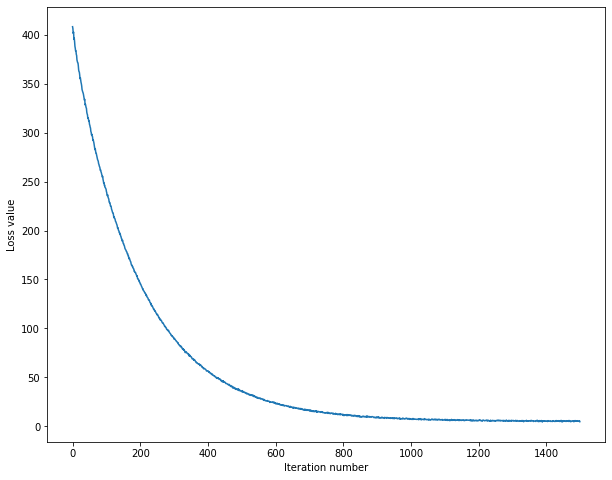

In [17]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [18]:
y_train_pred = svm.predict(x_train)
print('training accuracy: %f' %(np.mean(y_train == y_train_pred)))
y_val_pred = svm.predict(x_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.384776
validation accuracy: 0.399000


iteration 0 / 1500: loss 407.768026
iteration 100 / 1500: loss 241.241946
iteration 200 / 1500: loss 147.589136
iteration 300 / 1500: loss 90.021062
iteration 400 / 1500: loss 57.099129
iteration 500 / 1500: loss 36.400032
iteration 600 / 1500: loss 23.024973
iteration 700 / 1500: loss 16.633885
iteration 800 / 1500: loss 11.758250
iteration 900 / 1500: loss 9.030262
iteration 1000 / 1500: loss 7.616495
iteration 1100 / 1500: loss 6.771849
iteration 1200 / 1500: loss 5.991871
iteration 1300 / 1500: loss 6.286739
iteration 1400 / 1500: loss 4.994466
iteration 0 / 1500: loss 405.812550
iteration 100 / 1500: loss 240.991810
iteration 200 / 1500: loss 147.698435
iteration 300 / 1500: loss 90.629504
iteration 400 / 1500: loss 56.896938
iteration 500 / 1500: loss 35.782363
iteration 600 / 1500: loss 24.066465
iteration 700 / 1500: loss 15.812263
iteration 800 / 1500: loss 11.404128
iteration 900 / 1500: loss 8.899574
iteration 1000 / 1500: loss 7.588445
iteration 1100 / 1500: loss 6.677718
i

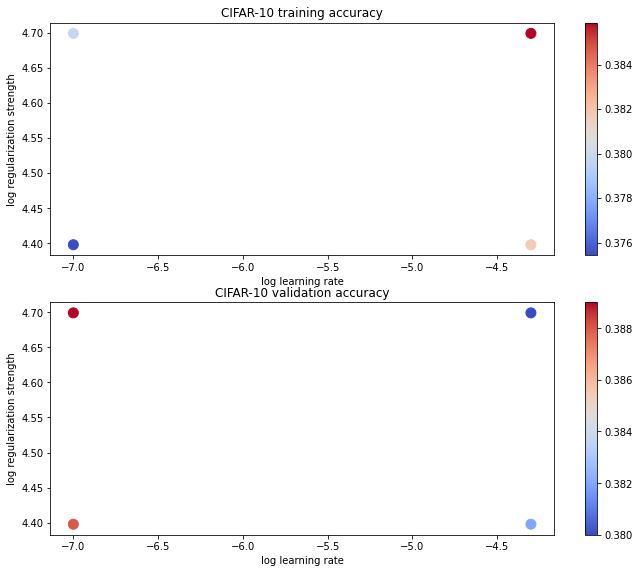

linear SVM on raw pixels final test set accuracy: 0.391000


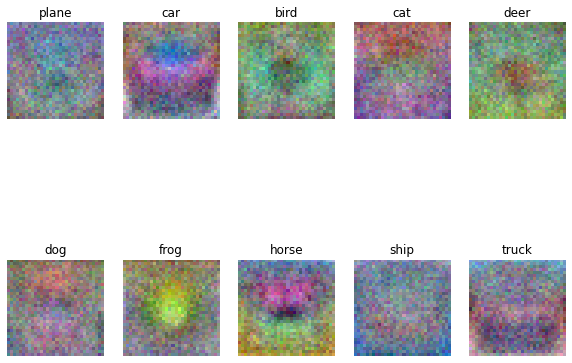

In [20]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(x_train, y_train, learning_rate=1e-7, reg=2.5e4, num_iters=1500, verbose=True)
        y_train_predcit = svm.predict(x_train)
        train_acc = np.mean(y_train_predcit == y_train)
        y_val_predcit = svm.predict(x_val)
        val_acc = np.mean(y_val_predcit == y_val)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
        results[(lr,rs)] = train_acc, val_acc
        
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(x_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

In [21]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(x_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.391000


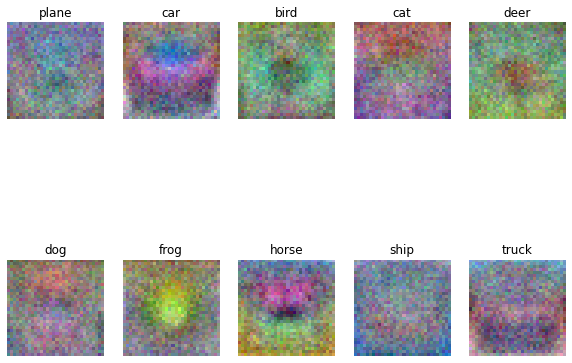

In [23]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])